In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install pandas
!pip install pytorch-forecasting

ERROR: Could not find a version that satisfies the requirement pytorch-forecasting (from versions: none)
ERROR: No matching distribution found for pytorch-forecasting


In [3]:
import os
print(os.listdir("/kaggle/input"))  # bạn sẽ thấy folder dataset, ví dụ 'smart-meters-in-london'
dataset_root = "/kaggle/input/smart-meters-in-london"   # chỉnh theo tên folder hiện ra
print(os.listdir(dataset_root)[:50])

['smart-meters-in-london']
['darksky_parameters_documentation.html', 'weather_hourly_darksky.csv', 'hhblock_dataset', 'halfhourly_dataset', 'acorn_details.csv', 'uk_bank_holidays.csv', 'weather_daily_darksky.csv', 'daily_dataset', 'daily_dataset.csv', 'informations_households.csv']


In [4]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/kaggle/input/smart-meters-in-london")
data = pd.read_csv(DATA_DIR / "daily_dataset.csv")
print("shape:", data.shape)
data['day'] = pd.to_datetime(data['day'])
data.head()

shape: (3510433, 9)


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [5]:
# Weather
weather = pd.read_csv(DATA_DIR / "weather_daily_darksky.csv")
# weather['time'] có thể là epoch (s) hoặc date string
if weather['time'].dtype.kind in 'iuf':
    weather['day'] = pd.to_datetime(weather['time'], unit='s', errors='coerce')
else:
    weather['day'] = pd.to_datetime(weather['time'], errors='coerce')

# keep a few columns
weather = weather[['day','temperatureMax','temperatureMin','humidity','windSpeed','visibility','pressure']].copy()
weather['day'] = weather['day'].dt.normalize()

# Holidays
hol = pd.read_csv(DATA_DIR / "uk_bank_holidays.csv")
hol = hol.rename(columns={hol.columns[0]: 'day'})
hol['day'] = pd.to_datetime(hol['day']).dt.normalize()
hol = hol[['day']].drop_duplicates()
hol['is_holiday'] = 1

# Household info
hh = pd.read_csv(DATA_DIR / "informations_households.csv", dtype={'LCLid':'string'})
# keep columns used by notebook (Tariff, Acorn)
hh = hh.rename(columns={'stdorToU':'Tariff','Acorn':'AcornGroup'}) if 'stdorToU' in hh.columns else hh
hh = hh[['LCLid','Tariff','AcornGroup']].drop_duplicates(subset=['LCLid'])

# Merge
data['day'] = data['day'].dt.normalize()
df = data.merge(weather, on='day', how='left')
df = df.merge(hol[['day','is_holiday']], on='day', how='left')
df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
df = df.merge(hh, on='LCLid', how='left')
# weekend flag
df['is_weekend'] = df['day'].dt.weekday.isin([5,6]).astype(int)
df['holiday'] = ((df['is_holiday']==1) | (df['is_weekend']==1)).astype(int)
df.shape

(3517032, 20)

In [6]:
# lấy top 200 households có nhiều ngày nhất (điều chỉnh N tùy RAM)
counts = df.groupby('LCLid')['day'].nunique().sort_values(ascending=False)
sample_ids = counts.head(200).index.tolist()
df_small = df[df['LCLid'].isin(sample_ids)].copy()
print("rows:", len(df_small), "unique LCLid:", df_small['LCLid'].nunique())

rows: 164040 unique LCLid: 200


In [8]:
df_small = df_small.sort_values(['LCLid','day']).reset_index(drop=True)
df_small['dayofweek'] = df_small['day'].dt.dayofweek
df_small['month'] = df_small['day'].dt.month

# create lags (1,2,3,7,14)
lags = [1,2,3,7,14]
for lag in lags:
    df_small[f'lag_{lag}'] = df_small.groupby('LCLid')['energy_sum'].shift(lag)

# rolling mean
df_small['roll_mean_7'] = df_small.groupby('LCLid')['energy_sum'].shift(1).rolling(7).mean().reset_index(level=0, drop=True)

In [10]:
from sklearn.preprocessing import LabelEncoder

for col in ['Tariff','AcornGroup']:
    df_small[col] = df_small[col].fillna('Unknown')
    le = LabelEncoder()
    df_small[col+'_enc'] = le.fit_transform(df_small[col])

In [11]:
cutoff_date = pd.to_datetime("2014-01-01")
train = df_small[df_small['day'] < cutoff_date].dropna()
test = df_small[df_small['day'] >= cutoff_date].copy()
print(train.shape, test.shape)

(148977, 30) (11800, 30)


In [12]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

features = ['dayofweek','month','roll_mean_7'] + [f'lag_{l}' for l in lags] + ['temperatureMax','temperatureMin','humidity','is_weekend','holiday','Tariff_enc','AcornGroup_enc']
# fillna
train[features] = train[features].fillna(0)
test[features]  = test[features].fillna(0)

X_train = train[features]
y_train = train['energy_sum']
X_test = test[features]
y_test = test['energy_sum']

model = xgb.XGBRegressor(n_estimators=300, max_depth=6, tree_method='hist', random_state=42, n_jobs=4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

RMSE: 4.05454332017224
MAE: 2.330305242202106


In [13]:
import pandas as pd

def forecast_recursive_for_household(house_id, last_row, model, features, horizon=7):
    preds = []
    cur = last_row.copy()
    # ensure index as columns
    for h in range(horizon):
        X = cur[features].values.reshape(1,-1)
        p = model.predict(X)[0]
        preds.append(p)
        # shift lags
        for lag in sorted(lags, reverse=True):
            if lag==1:
                cur[f'lag_{lag}'] = p
            else:
                cur[f'lag_{lag}'] = cur.get(f'lag_{lag-1}', 0)
        # update rolling mean crudely: roll mean <- current mean (approx)
        # advance day
        cur['day'] = cur['day'] + pd.Timedelta(days=1)
        cur['dayofweek'] = cur['day'].weekday()
        cur['month'] = cur['day'].month
        # you may set cur['temperatureMax'] = last known or climatology
    return preds

# ví dụ forecast 7 ngày cho 1 hộ:
last_obs = df_small[df_small['LCLid']==sample_ids[0]].sort_values('day').iloc[-1]
preds7 = forecast_recursive_for_household(sample_ids[0], last_obs, model, features, horizon=7)
print(preds7)

[31.278196, 30.626053, 28.066336, 31.309696, 22.753681, 27.181808, 34.092026]


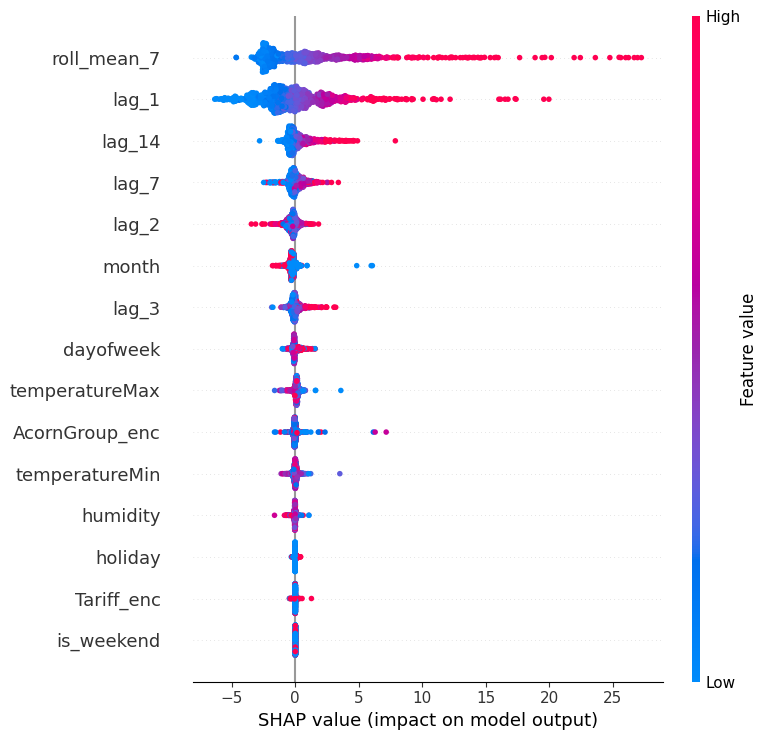

In [14]:
import shap
explainer = shap.TreeExplainer(model)
# sample small set to compute shap values
X_sample = X_test.sample(1000, random_state=1)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

In [15]:
# lưu model
import joblib
joblib.dump(model, "/kaggle/working/xgb_model.joblib")

# lưu predictions
out = test[['LCLid','day']].copy()
out['y_true'] = y_test.values
out['y_pred'] = y_pred
out.to_csv("/kaggle/working/predictions.csv", index=False)

Kích thước tập train: (2808346, 9)
Kích thước tập test: (702087, 9)


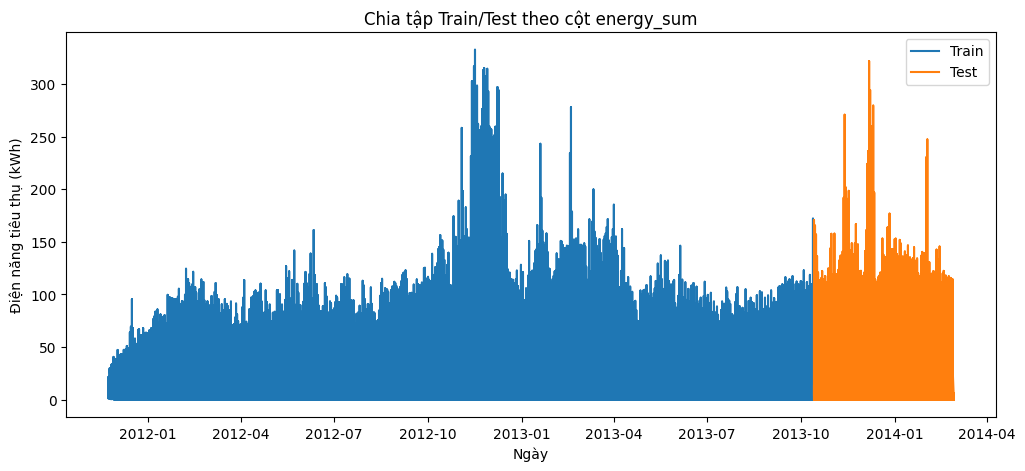

In [18]:
import pandas as pd

# Sắp xếp dữ liệu theo ngày
data = data.sort_values("day")

# Chia theo thời gian: 80% train, 20% test
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print("Kích thước tập train:", train_data.shape)
print("Kích thước tập test:", test_data.shape)

# Vẽ thử
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_data["day"], train_data["energy_sum"], label="Train")
plt.plot(test_data["day"], test_data["energy_sum"], label="Test")
plt.xlabel("Ngày")
plt.ylabel("Điện năng tiêu thụ (kWh)")
plt.title("Chia tập Train/Test theo cột energy_sum")
plt.legend()
plt.show()

In [17]:
print(data.columns)

Index(['LCLid', 'day', 'energy_median', 'energy_mean', 'energy_max',
       'energy_count', 'energy_std', 'energy_sum', 'energy_min'],
      dtype='object')


In [19]:
# Sao chép dữ liệu để xử lý
df_proc = df.copy()

# Chọn cột ngày
df_proc["day"] = pd.to_datetime(df_proc["day"])

# Thêm các đặc trưng thời gian
df_proc["dayofweek"] = df_proc["day"].dt.dayofweek   # Thứ (0=Monday, 6=Sunday)
df_proc["month"] = df_proc["day"].dt.month
df_proc["is_weekend"] = df_proc["dayofweek"].isin([5,6]).astype(int)

# Nếu có bảng holidays thì merge thêm
# holidays["day"] = pd.to_datetime(holidays["day"])
# df_proc = df_proc.merge(holidays, on="day", how="left")
# df_proc["holiday"] = df_proc["holiday"].fillna(0).astype(int)

print(df_proc.head())

       LCLid        day  energy_median  energy_mean  energy_max  energy_count  \
0  MAC000131 2011-12-15         0.4850     0.432045       0.868            22   
1  MAC000131 2011-12-16         0.1415     0.296167       1.116            48   
2  MAC000131 2011-12-17         0.1015     0.189812       0.685            48   
3  MAC000131 2011-12-18         0.1140     0.218979       0.676            48   
4  MAC000131 2011-12-19         0.1910     0.325979       0.788            48   

   energy_std  energy_sum  energy_min  temperatureMax  ...  windSpeed  \
0    0.239146       9.505       0.072            7.97  ...       4.71   
1    0.281471      14.216       0.031            4.68  ...       3.71   
2    0.188405       9.111       0.064            5.35  ...       3.99   
3    0.202919      10.511       0.065            5.49  ...       3.60   
4    0.259205      15.647       0.066            6.64  ...       2.70   

   visibility  pressure  is_holiday  Tariff  AcornGroup is_weekend holiday

In [20]:
# Chỉ lấy cột thời gian và energy_sum
df_arima = df_proc[["day", "energy_sum"]].set_index("day")

print(df_arima.head())

            energy_sum
day                   
2011-12-15       9.505
2011-12-16      14.216
2011-12-17       9.111
2011-12-18      10.511
2011-12-19      15.647


In [21]:
!pip install pmdarima

import pmdarima as pm

# Train trên tập train
train_series = df_arima["energy_sum"][:-30]   # lấy toàn bộ trừ 30 ngày cuối
test_series = df_arima["energy_sum"][-30:]   # 30 ngày cuối làm test

# Auto ARIMA
model_arima = pm.auto_arima(train_series, seasonal=True, m=7, trace=True)
forecast_arima = model_arima.predict(n_periods=30)

# So sánh kết quả
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(train_series.index, train_series, label="Train")
plt.plot(test_series.index, test_series, label="Test")
plt.plot(test_series.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.show()

ERROR: Could not find a version that satisfies the requirement pmdarima (from versions: none)
ERROR: No matching distribution found for pmdarima


ModuleNotFoundError: No module named 'pmdarima'

No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.
No frequency information was provided, so inferred frequency D will be used.


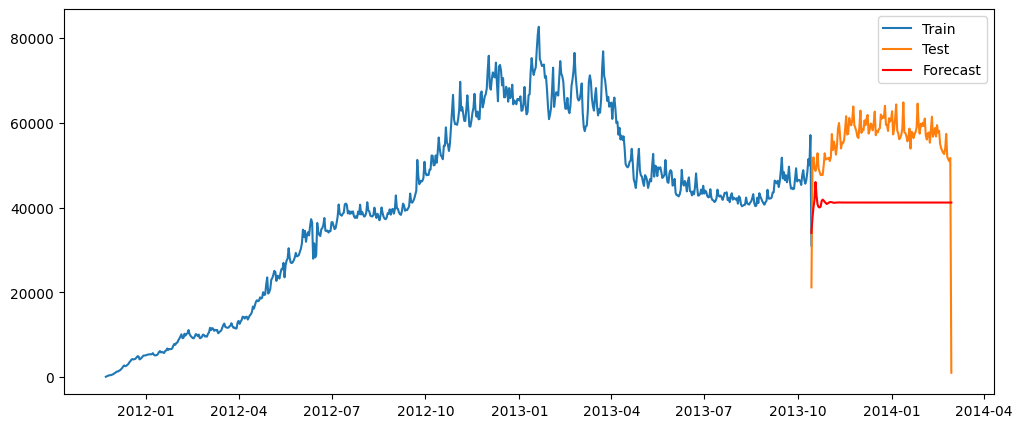

In [22]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# lấy dữ liệu theo ngày tổng hợp (ví dụ energy_sum trung bình)
ts = train_data.groupby("day")["energy_sum"].sum()

# train ARIMA(5,1,0) ví dụ
model = ARIMA(ts, order=(5,1,0))
model_fit = model.fit()

# dự báo
forecast = model_fit.forecast(steps=len(test_data["day"].unique()))

# vẽ
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label="Train")
plt.plot(test_data["day"].unique(), test_data.groupby("day")["energy_sum"].sum(), label="Test")
plt.plot(test_data["day"].unique(), forecast, label="Forecast", color="red")
plt.legend()
plt.show()

In [24]:
customer_id = df['LCLid'].unique()[0]
df_customer = df[df['LCLid'] == customer_id][['day', 'energy_sum']].copy()
df_customer = df_customer.sort_values('day')

In [26]:
train = df_customer.iloc[:-30]
test = df_customer.iloc[-30:]

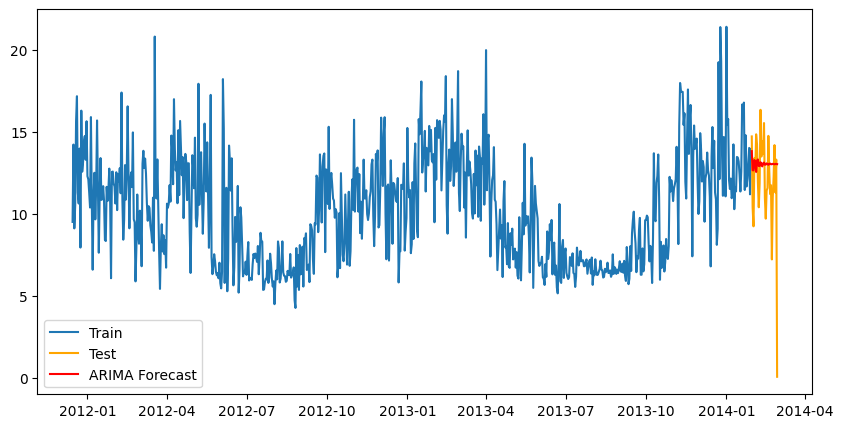

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(p,d,q), ví dụ (7,1,1) bạn có thể tinh chỉnh bằng AIC/BIC
model = ARIMA(train['energy_sum'], order=(7,1,1))
model_fit = model.fit()

# Dự báo số ngày bằng số test
forecast = model_fit.forecast(steps=len(test))

# So sánh
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train['day'], train['energy_sum'], label='Train')
plt.plot(test['day'], test['energy_sum'], label='Test', color='orange')
plt.plot(test['day'], forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

03:01:30 - cmdstanpy - INFO - Chain [1] start processing
03:01:30 - cmdstanpy - INFO - Chain [1] done processing


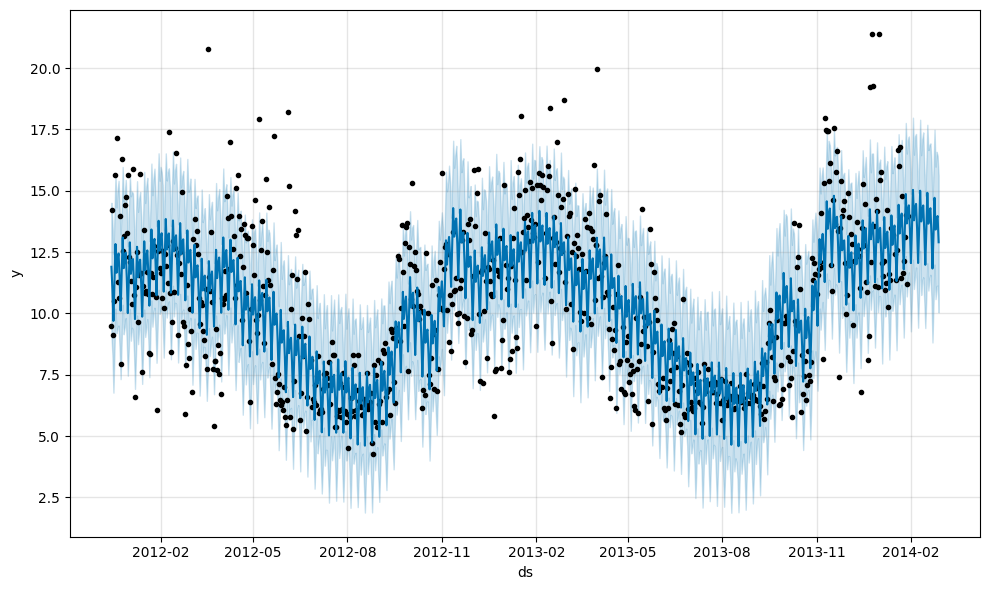

In [28]:
from prophet import Prophet

df_prophet = df_customer.rename(columns={'day':'ds', 'energy_sum':'y'})

train_prophet = df_prophet.iloc[:-30]
test_prophet = df_prophet.iloc[-30:]

m = Prophet()
m.fit(train_prophet)

future = m.make_future_dataframe(periods=len(test_prophet))
forecast = m.predict(future)

fig = m.plot(forecast)

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test['energy_sum'].values
y_pred = forecast[:len(test)]  # nếu là ARIMA

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['energy_sum'], forecast)
rmse = np.sqrt(mean_squared_error(test['energy_sum'], forecast))
mape = np.mean(np.abs((test['energy_sum'] - forecast)/test['energy_sum'])) * 100

print(f'ARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

ValueError: Found input variables with inconsistent numbers of samples: [30, 807]

In [31]:
print(len(forecast))

807


In [33]:
# forecast có thể là pd.Series với index là ngày từ train
# cắt phần tương ứng với test
forecast_test = forecast[-len(test):]

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['energy_sum'], forecast_test)
rmse = np.sqrt(mean_squared_error(test['energy_sum'], forecast_test))
mape = np.mean(np.abs((test['energy_sum'] - forecast_test)/test['energy_sum'])) * 100

print(f'ARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [36]:
# Nếu forecast_test là Series với index là ngày, chỉ lấy giá trị float
forecast_values = forecast_test.values  # chuyển thành mảng float

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['energy_sum'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['energy_sum'], forecast_values))
mape = np.mean(np.abs((test['energy_sum'] - forecast_values)/test['energy_sum'])) * 100

print(f'ARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

TypeError: float() argument must be a string or a real number, not 'Timestamp'

ARIMA MAE: 2.07, RMSE: 3.11, MAPE: 590.31%


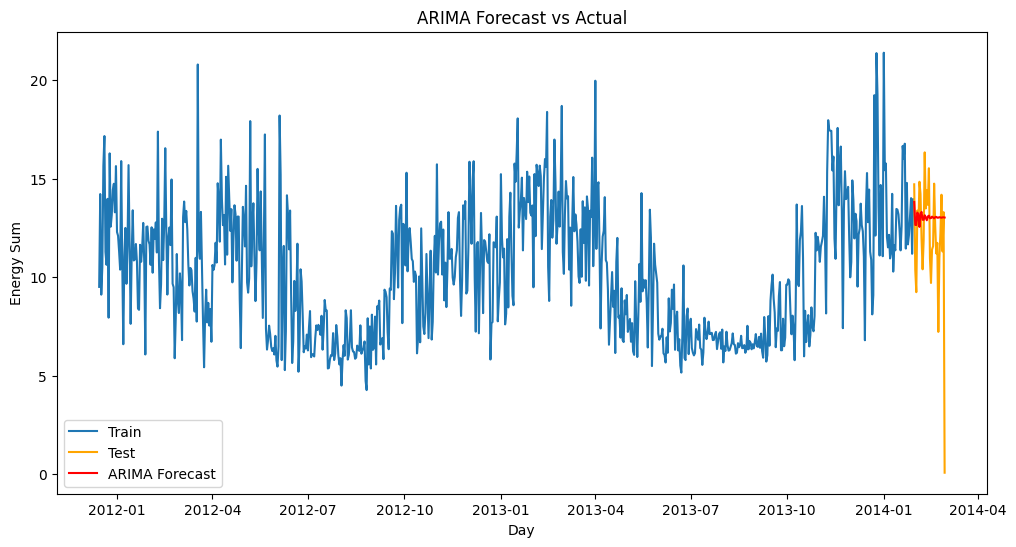

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Giả sử df_customer có cột 'day' (datetime) và 'energy_sum' (float)
# Chia train/test
train = df_customer.iloc[:-30]
test = df_customer.iloc[-30:]

# Fit ARIMA(p,d,q) - ví dụ (7,1,1)
model = ARIMA(train['energy_sum'], order=(7,1,1))
model_fit = model.fit()

# Forecast cho số bước = độ dài test
forecast = model_fit.forecast(steps=len(test))

# Chỉ lấy giá trị float (loại bỏ datetime index)
forecast_values = forecast.to_numpy()

# Tính metric
mae = mean_absolute_error(test['energy_sum'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['energy_sum'], forecast_values))
mape = np.mean(np.abs((test['energy_sum'] - forecast_values)/test['energy_sum'])) * 100

print(f'ARIMA MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Vẽ đồ thị train, test, forecast
plt.figure(figsize=(12,6))
plt.plot(train['day'], train['energy_sum'], label='Train')
plt.plot(test['day'], test['energy_sum'], label='Test', color='orange')
plt.plot(test['day'], forecast_values, label='ARIMA Forecast', color='red')
plt.xlabel('Day')
plt.ylabel('Energy Sum')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [39]:
# Lấy phần dự báo tương ứng với test
forecast_test = forecast.iloc[-len(test):]['yhat'].to_numpy()

# Tính metric
mae_p = mean_absolute_error(test['energy_sum'], forecast_test)
rmse_p = np.sqrt(mean_squared_error(test['energy_sum'], forecast_test))
mape_p = np.mean(np.abs((test['energy_sum'] - forecast_test)/test['energy_sum'])) * 100

print(f'Prophet MAE: {mae_p:.2f}, RMSE: {rmse_p:.2f}, MAPE: {mape_p:.2f}%')

# Vẽ so sánh ARIMA vs Prophet
plt.figure(figsize=(12,6))
plt.plot(train['day'], train['energy_sum'], label='Train')
plt.plot(test['day'], test['energy_sum'], label='Test', color='orange')
plt.plot(test['day'], forecast_values, label='ARIMA Forecast', color='red')
plt.plot(test['day'], forecast_test, label='Prophet Forecast', color='green')
plt.xlabel('Day')
plt.ylabel('Energy Sum')
plt.title('ARIMA vs Prophet Forecast')
plt.legend()
plt.show()

KeyError: 'yhat'

In [1]:
import pandas as pd
import os

# 1. Đọc thông tin hộ gia đình
info = pd.read_csv('/kaggle/input/smart-meters-in-london/informations_households.csv')
print("Thông tin hộ gia đình:")
print(info.head())
print(info.columns)

# 2. Đọc tất cả file CSV trong hhblock_dataset
folder_path = '/kaggle/input/smart-meters-in-london/hhblock_dataset/'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"Tìm thấy {len(all_files)} file CSV trong hhblock_dataset")

# Nối tất cả file lại
hh_list = []
for f in all_files:
    df = pd.read_csv(f)
    hh_list.append(df)

hh = pd.concat(hh_list, ignore_index=True)
hh['tstp'] = pd.to_datetime(hh['tstp'])
print("\nDữ liệu hhblock_dataset sau khi nối:")
print(hh.head())

# 3. Tổng hợp dữ liệu theo ngày
daily = hh.groupby(['LCLid', pd.Grouper(key='tstp', freq='D')])['energy (kWh/hh)'].sum().reset_index()
daily.rename(columns={'energy (kWh/hh)': 'daily_energy_kWh'}, inplace=True)
print("\nDữ liệu hàng ngày sau khi tổng hợp:")
print(daily.head())

# 4. Chọn một hộ mẫu
sample_id = daily['LCLid'].unique()[0]
daily_sample = daily[daily['LCLid'] == sample_id].copy()
daily_sample.set_index('tstp', inplace=True)
print(f"\nDữ liệu hàng ngày của hộ mẫu LCLid = {sample_id}:")
print(daily_sample.head())

# 5. Xử lý giá trị thiếu (nếu có)
daily_sample['daily_energy_kWh'].fillna(method='ffill', inplace=True)

Thông tin hộ gia đình:
       LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0
Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')
Tìm thấy 0 file CSV trong hhblock_dataset


ValueError: No objects to concatenate

In [2]:
import pandas as pd
import os
import zipfile

# 1. Đọc thông tin hộ gia đình
info = pd.read_csv('/kaggle/input/smart-meters-in-london/informations_households.csv')
print("Thông tin hộ gia đình:")
print(info.head())
print(info.columns)

# 2. Giải nén hhblock_dataset.zip
zip_path = '/kaggle/input/smart-meters-in-london/hhblock_dataset.zip'
extract_folder = '/kaggle/working/hhblock_dataset/'

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("✅ Đã giải nén hhblock_dataset.zip")

# 3. Đọc tất cả file CSV sau khi giải nén
all_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith('.csv')]
print(f"Tìm thấy {len(all_files)} file CSV trong hhblock_dataset")

# Nối tất cả file CSV
hh_list = []
for f in all_files:
    df = pd.read_csv(f)
    hh_list.append(df)

hh = pd.concat(hh_list, ignore_index=True)
hh['tstp'] = pd.to_datetime(hh['tstp'])
print("\nDữ liệu hhblock_dataset sau khi nối:")
print(hh.head())

Thông tin hộ gia đình:
       LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0
Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/smart-meters-in-london/hhblock_dataset.zip'

In [3]:
import os

base_path = "/kaggle/input/smart-meters-in-london"

for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

smart-meters-in-london/
    darksky_parameters_documentation.html
    weather_hourly_darksky.csv
    acorn_details.csv
    uk_bank_holidays.csv
    weather_daily_darksky.csv
    daily_dataset.csv
    informations_households.csv
    hhblock_dataset/
        hhblock_dataset/
            block_97.csv
            block_27.csv
            block_55.csv
            block_0.csv
            block_2.csv
            block_9.csv
            block_34.csv
            block_60.csv
            block_7.csv
            block_43.csv
            block_99.csv
            block_87.csv
            block_89.csv
            block_47.csv
            block_106.csv
            block_92.csv
            block_54.csv
            block_8.csv
            block_28.csv
            block_107.csv
            block_57.csv
            block_82.csv
            block_78.csv
            block_31.csv
            block_52.csv
            block_21.csv
            block_53.csv
            block_41.csv
            block_93.csv
    

In [4]:
import pandas as pd
import os

# 1. Đọc thông tin hộ gia đình
info = pd.read_csv('/kaggle/input/smart-meters-in-london/informations_households.csv')
print("Thông tin hộ gia đình:")
print(info.head())
print(info.columns)

# 2. Đọc tất cả file halfhourly (nửa giờ)
folder_path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/'

all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"Tìm thấy {len(all_files)} file CSV trong halfhourly_dataset")

# Nối tất cả file thành 1 DataFrame lớn
hh_list = []
for f in all_files[:5]:   # ⚠️ đọc thử 5 file trước cho nhanh, sau này có thể đọc hết
    df = pd.read_csv(f)
    hh_list.append(df)

hh = pd.concat(hh_list, ignore_index=True)
hh['tstp'] = pd.to_datetime(hh['tstp'])
print("\nDữ liệu halfhourly sau khi nối:")
print(hh.head())

Thông tin hộ gia đình:
       LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0
Index(['LCLid', 'stdorToU', 'Acorn', 'Acorn_grouped', 'file'], dtype='object')
Tìm thấy 112 file CSV trong halfhourly_dataset

Dữ liệu halfhourly sau khi nối:
       LCLid                tstp energy(kWh/hh)
0  MAC000047 2011-12-08 12:30:00          0.16 
1  MAC000047 2011-12-08 13:00:00         0.185 
2  MAC000047 2011-12-08 13:30:00         0.153 
3  MAC000047 2011-12-08 14:00:00         0.341 
4  MAC000047 2011-12-08 14:30:00         0.176 


In [5]:
import pandas as pd

# --- Xử lý cột thời gian ---
halfhourly["tstp"] = pd.to_datetime(halfhourly["tstp"], errors="coerce")

# --- Xử lý cột năng lượng ---
halfhourly["energy(kWh/hh)"] = (
    halfhourly["energy(kWh/hh)"]
    .str.strip()            # bỏ khoảng trắng
    .replace("", None)      # thay ô trống bằng None
    .astype(float)          # chuyển thành float
)

# --- Kiểm tra dữ liệu bị thiếu ---
missing_summary = halfhourly.isnull().sum()

print("✅ Tiền xử lý xong!")
print(missing_summary.head(10))  # in 10 dòng đầu của thống kê missing values
print(halfhourly.dtypes)         # kiểm tra kiểu dữ liệu sau khi xử lý

NameError: name 'halfhourly' is not defined

In [6]:
import os
import pandas as pd

folder_path = "/kaggle/input/smart-meters-in-london/halfhourly_dataset/"

# lấy danh sách file CSV
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# đọc và nối lại
df_list = [pd.read_csv(f) for f in all_files]
halfhourly = pd.concat(df_list, ignore_index=True)

print("✅ Đã tạo halfhourly với kích thước:", halfhourly.shape)
print(halfhourly.head())

ValueError: No objects to concatenate

In [7]:
import os

folder_path = "/kaggle/input/smart-meters-in-london/halfhourly_dataset/"
print("Thư mục tồn tại?", os.path.exists(folder_path))
print("Các file trong thư mục:", os.listdir(folder_path)[:10])  # in thử 10 file đầu

Thư mục tồn tại? True
Các file trong thư mục: ['halfhourly_dataset']


In [8]:
import os

subfolder = "/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/"
print("Các file trong subfolder:", os.listdir(subfolder)[:10])

Các file trong subfolder: ['block_97.csv', 'block_27.csv', 'block_55.csv', 'block_0.csv', 'block_2.csv', 'block_9.csv', 'block_34.csv', 'block_60.csv', 'block_7.csv', 'block_43.csv']


In [10]:
import pandas as pd
import os

# Đường dẫn đến folder chứa CSV
subfolder = "/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/"

# Lấy danh sách file .csv
all_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(".csv")]
print("Tìm thấy", len(all_files), "file CSV")

# Đọc và nối lại
df_list = [pd.read_csv(f) for f in all_files]
halfhourly = pd.concat(df_list, ignore_index=True)

print("✅ Đã tạo halfhourly với kích thước:", halfhourly.shape)
print(halfhourly.head())

Tìm thấy 112 file CSV


/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in all_files]
/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in all_files]
/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in all_files]
/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in all_files]
/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in all_files]
/tmp/ipykernel_36/3564277180.py:12: DtypeWarning: Columns (2) have mixed types. 

✅ Đã tạo halfhourly với kích thước: (167817021, 3)
       LCLid                         tstp energy(kWh/hh)
0  MAC000047  2011-12-08 12:30:00.0000000          0.16 
1  MAC000047  2011-12-08 13:00:00.0000000         0.185 
2  MAC000047  2011-12-08 13:30:00.0000000         0.153 
3  MAC000047  2011-12-08 14:00:00.0000000         0.341 
4  MAC000047  2011-12-08 14:30:00.0000000         0.176 


In [13]:
# --- Xử lý cột thời gian ---
halfhourly["tstp"] = pd.to_datetime(halfhourly["tstp"], errors="coerce")

# --- Xử lý cột năng lượng ---
halfhourly["energy(kWh/hh)"] = pd.to_numeric(
    halfhourly["energy(kWh/hh)"].astype(str).str.strip(), 
    errors="coerce"
)

# --- Kiểm tra dữ liệu ---
print("📌 Sau khi chuẩn hóa:")
print(halfhourly.dtypes)
print(halfhourly.head())

# Kiểm tra giá trị null
print("\nSố lượng giá trị null mỗi cột:")
print(halfhourly.isnull().sum())

📌 Sau khi chuẩn hóa:
LCLid                     object
tstp              datetime64[ns]
energy(kWh/hh)           float64
dtype: object
       LCLid                tstp  energy(kWh/hh)
0  MAC000047 2011-12-08 12:30:00           0.160
1  MAC000047 2011-12-08 13:00:00           0.185
2  MAC000047 2011-12-08 13:30:00           0.153
3  MAC000047 2011-12-08 14:00:00           0.341
4  MAC000047 2011-12-08 14:30:00           0.176

Số lượng giá trị null mỗi cột:
LCLid                0
tstp                 0
energy(kWh/hh)    5560
dtype: int64


In [1]:
# --- Tổng hợp dữ liệu ---
# Theo ngày
daily = halfhourly.groupby(["LCLid", pd.Grouper(key="tstp", freq="D")])["energy(kWh/hh)"].sum().reset_index()

# Theo tuần
weekly = halfhourly.groupby(["LCLid", pd.Grouper(key="tstp", freq="W")])["energy(kWh/hh)"].sum().reset_index()

# Theo tháng
monthly = halfhourly.groupby(["LCLid", pd.Grouper(key="tstp", freq="M")])["energy(kWh/hh)"].sum().reset_index()

# In thử kết quả
print("✅ Kích thước daily:", daily.shape)
print(daily.head())

print("\n✅ Kích thước weekly:", weekly.shape)
print(weekly.head())

print("\n✅ Kích thước monthly:", monthly.shape)
print(monthly.head())

NameError: name 'halfhourly' is not defined

In [2]:
import pandas as pd
import os

# --- Bước 1: Đọc dữ liệu ---
subfolder = "/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/"
all_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(".csv")]

df_list = [pd.read_csv(f, low_memory=False) for f in all_files]
halfhourly = pd.concat(df_list, ignore_index=True)

# --- Bước 2: Chuẩn hóa dữ liệu ---
halfhourly["tstp"] = pd.to_datetime(halfhourly["tstp"], errors="coerce")
halfhourly["energy(kWh/hh)"] = pd.to_numeric(halfhourly["energy(kWh/hh)"], errors="coerce")

# --- Bước 3: Tổng hợp dữ liệu ---
# Theo ngày
daily = halfhourly.groupby(
    ["LCLid", pd.Grouper(key="tstp", freq="D")]
)["energy(kWh/hh)"].sum().reset_index()

# Theo tuần
weekly = halfhourly.groupby(
    ["LCLid", pd.Grouper(key="tstp", freq="W")]
)["energy(kWh/hh)"].sum().reset_index()

# Theo tháng
monthly = halfhourly.groupby(
    ["LCLid", pd.Grouper(key="tstp", freq="M")]
)["energy(kWh/hh)"].sum().reset_index()

print("✅ Kích thước daily:", daily.shape)
print(daily.head())
print("\n✅ Kích thước weekly:", weekly.shape)
print(weekly.head())
print("\n✅ Kích thước monthly:", monthly.shape)
print(monthly.head())

/tmp/ipykernel_92/917531183.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ["LCLid", pd.Grouper(key="tstp", freq="M")]


✅ Kích thước daily: (3510433, 3)
       LCLid       tstp  energy(kWh/hh)
0  MAC000002 2012-10-12           7.098
1  MAC000002 2012-10-13          11.087
2  MAC000002 2012-10-14          13.223
3  MAC000002 2012-10-15          10.257
4  MAC000002 2012-10-16           9.769

✅ Kích thước weekly: (505290, 3)
       LCLid       tstp  energy(kWh/hh)
0  MAC000002 2012-10-14          31.408
1  MAC000002 2012-10-21          91.961
2  MAC000002 2012-10-28         109.615
3  MAC000002 2012-11-04         100.179
4  MAC000002 2012-11-11          80.747

✅ Kích thước monthly: (118478, 3)
       LCLid       tstp  energy(kWh/hh)
0  MAC000002 2012-10-31         277.546
1  MAC000002 2012-11-30         344.762
2  MAC000002 2012-12-31         355.524
3  MAC000002 2013-01-31         359.872
4  MAC000002 2013-02-28         381.622


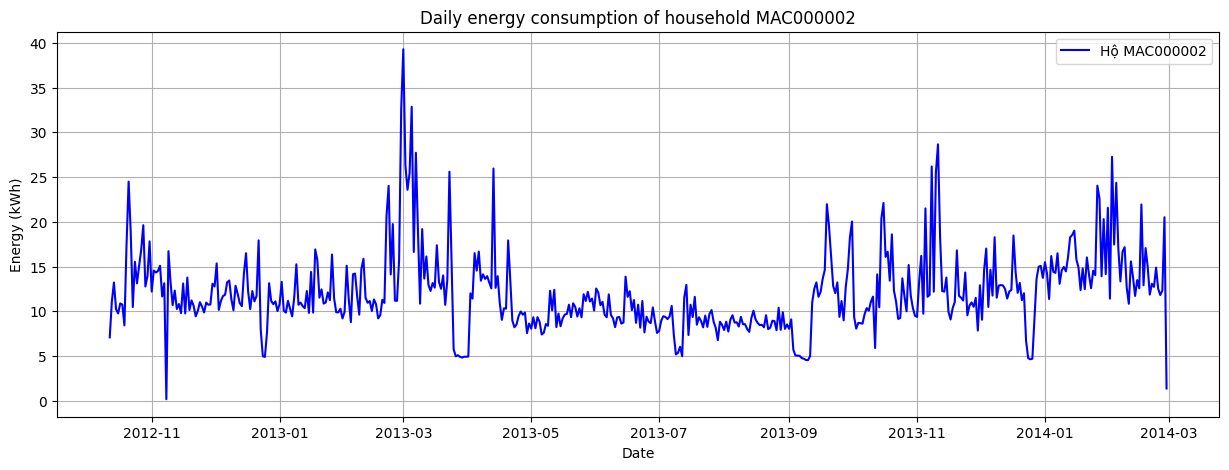

In [3]:
import matplotlib.pyplot as plt

# --- Lọc dữ liệu của một hộ gia đình ---
household_id = "MAC000002"
df_house = daily[daily["LCLid"] == household_id]

# --- Vẽ biểu đồ ---
plt.figure(figsize=(15,5))
plt.plot(df_house["tstp"], df_house["energy(kWh/hh)"], label=f"Hộ {household_id}", color="blue")

plt.title(f"Daily energy consumption of household {household_id}")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.show()

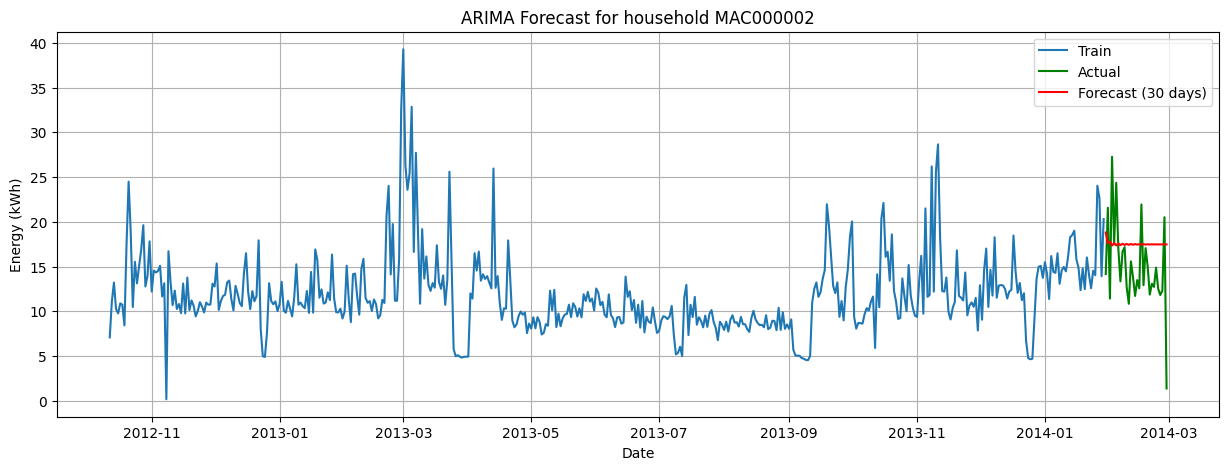

In [5]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# --- Lấy dữ liệu daily của hộ đã chọn ---
household_id = "MAC000002"
df_house = daily[daily["LCLid"] == household_id].copy()

# Đặt cột thời gian làm index
df_house = df_house.set_index("tstp").asfreq("D")

# Chỉ lấy cột energy
y = df_house["energy(kWh/hh)"]

# --- Train ARIMA ---
# Chia dữ liệu: train = tất cả trừ 30 ngày cuối, test = 30 ngày cuối
train = y.iloc[:-30]
test = y.iloc[-30:]

# Fit mô hình ARIMA (p,d,q) đơn giản
model = sm.tsa.ARIMA(train, order=(2,1,2))
model_fit = model.fit()

# --- Dự đoán ---
forecast = model_fit.forecast(steps=30)

# --- Vẽ biểu đồ ---
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual", color="green")
plt.plot(test.index, forecast, label="Forecast (30 days)", color="red")

plt.title(f"ARIMA Forecast for household {household_id}")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Tính toán các chỉ số ---
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("📊 Đánh giá mô hình ARIMA:")
print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("MAPE:", round(mape, 2), "%")

📊 Đánh giá mô hình ARIMA:
MAE : 4.457
RMSE: 5.413
MAPE: 66.12 %


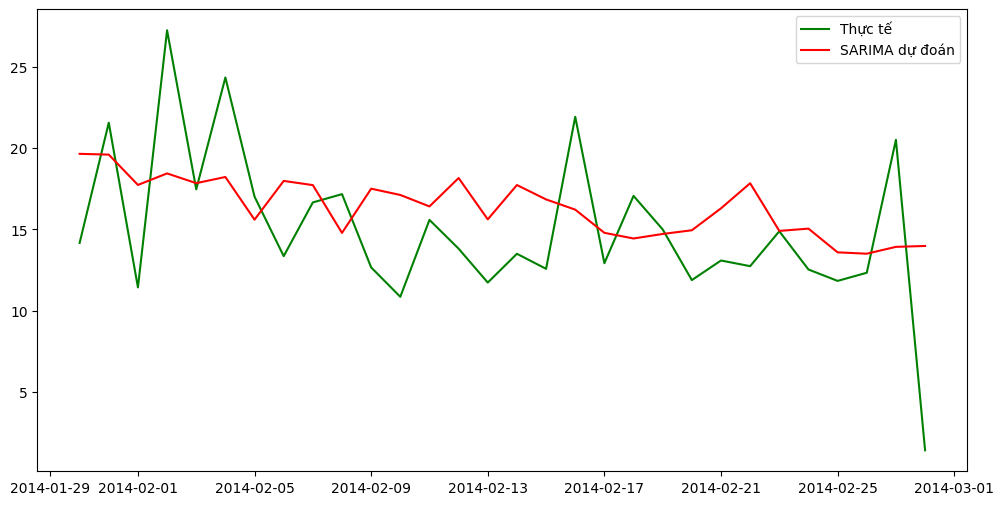

In [7]:
import statsmodels.api as sm

# SARIMA(p,d,q)(P,D,Q,s)
# s = 48 (chu kỳ trong ngày vì dữ liệu half-hourly = 48 điểm/ngày)
sarima_model = sm.tsa.statespace.SARIMAX(train,
                                         order=(2,1,2),
                                         seasonal_order=(1,1,1,48),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Thực tế", color="green")
plt.plot(test.index, sarima_forecast, label="SARIMA dự đoán", color="red")
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, sarima_forecast)
rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100

print("Đánh giá SARIMA:")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("MAPE:", round(mape, 2), "%")

Đánh giá SARIMA:
MAE: 3.797
RMSE: 4.676
MAPE: 53.03 %


In [9]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import pandas as pd

# --- Chuẩn bị dữ liệu cho Prophet ---
# Prophet yêu cầu cột "ds" (datetime) và "y" (giá trị cần dự đoán)
df_prophet = household_df[['tstp', 'energy(kWh/hh)']].rename(
    columns={"tstp": "ds", "energy(kWh/hh)": "y"}
)

# --- Chia train/test ---
train_size = int(len(df_prophet) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

# --- Khởi tạo và train mô hình Prophet ---
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

# --- Dự báo ---
future = model.make_future_dataframe(periods=len(test), freq="D")  # dự báo số ngày bằng test set
forecast = model.predict(future)

# --- Trực quan kết quả ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train", color="blue")
plt.plot(test["ds"], test["y"], label="Thực tế", color="green")
plt.plot(test["ds"], forecast.iloc[-len(test):]["yhat"], label="Prophet dự đoán", color="red")
plt.legend()
plt.title("Prophet dự báo tiêu thụ điện")
plt.show()

# --- Đánh giá mô hình ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = test["y"].values
y_pred = forecast.iloc[-len(test):]["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Đánh giá Prophet:")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("MAPE:", round(mape, 2), "%")

NameError: name 'household_df' is not defined

In [10]:
# --- Chọn 1 hộ gia đình để dự báo ---
household_id = "MAC000002"   # bạn có thể đổi sang bất kỳ LCLid nào
household_df = daily[daily["LCLid"] == household_id].copy()

print("Kích thước household_df:", household_df.shape)
print(household_df.head())

Kích thước household_df: (505, 3)
       LCLid       tstp  energy(kWh/hh)
0  MAC000002 2012-10-12           7.098
1  MAC000002 2012-10-13          11.087
2  MAC000002 2012-10-14          13.223
3  MAC000002 2012-10-15          10.257
4  MAC000002 2012-10-16           9.769


13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing


Đánh giá Prophet:
MAE: 2.729
RMSE: 4.150
MAPE: 39.05 %


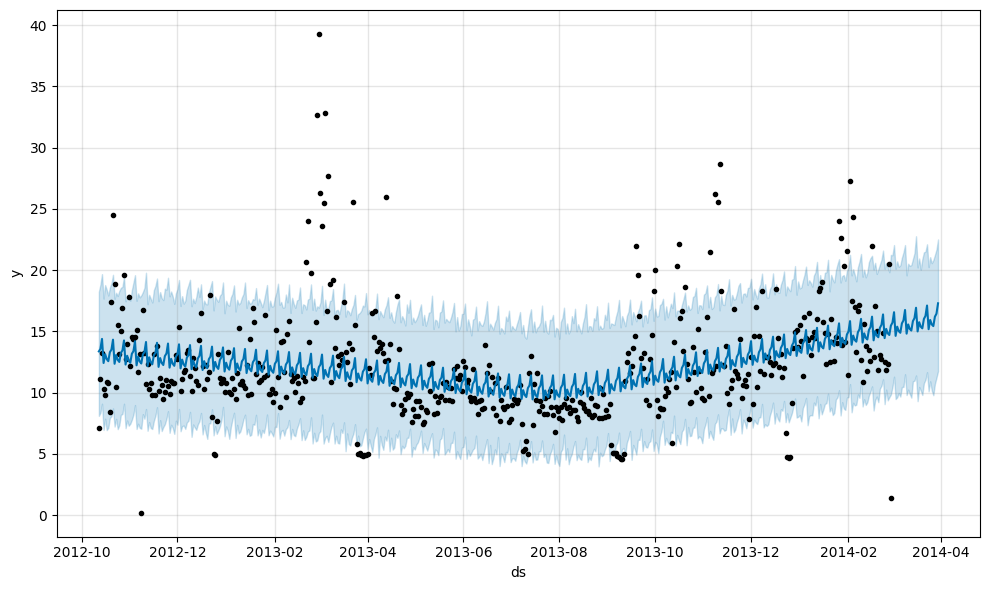

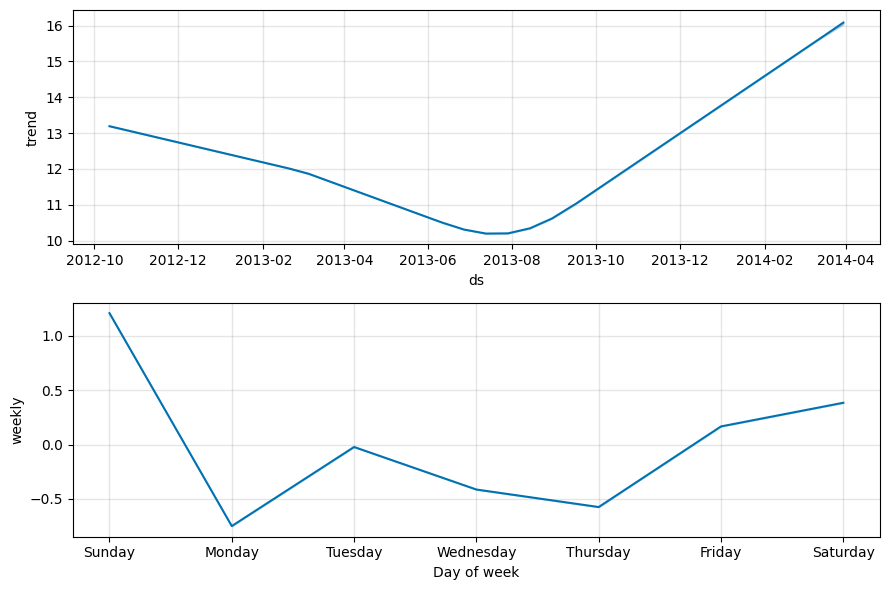

In [11]:
from prophet import Prophet

# --- Chuẩn bị dữ liệu cho Prophet ---
df_prophet = household_df[['tstp', 'energy(kWh/hh)']].rename(
    columns={"tstp": "ds", "energy(kWh/hh)": "y"}
)

# Khởi tạo mô hình Prophet
model = Prophet()

# Huấn luyện
model.fit(df_prophet)

# Dự báo 30 ngày tiếp theo
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# --- Vẽ kết quả ---
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

# --- Đánh giá trên tập dữ liệu thật (nếu có dữ liệu test) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cắt forecast để so sánh với dữ liệu gốc
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
real_df = df_prophet.set_index('ds')

common_index = forecast_df.index.intersection(real_df.index)

y_true = real_df.loc[common_index, 'y']
y_pred = forecast_df.loc[common_index, 'yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100

print("Đánh giá Prophet:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f} %")

📊 So sánh kết quả các mô hình dự báo:
           MAE   RMSE   MAPE
ARIMA    4.457  5.413  66.12
SARIMA   3.797  4.676  53.03
Prophet  2.729  4.150  39.05


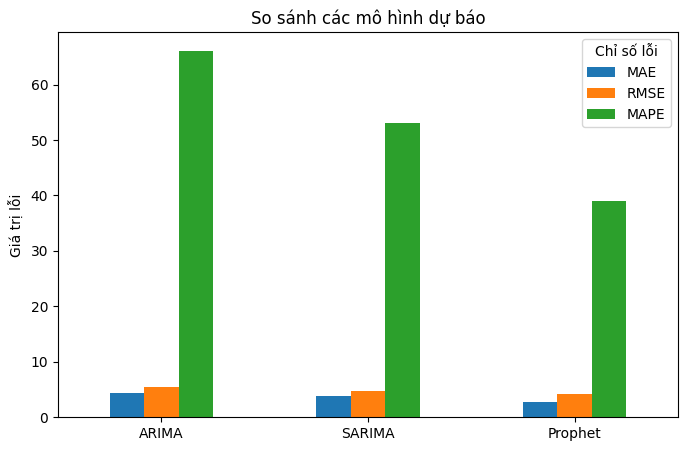

In [12]:
import pandas as pd

# --- Lưu kết quả đánh giá ---
results = {
    "ARIMA": {"MAE": 4.457, "RMSE": 5.413, "MAPE": 66.12},
    "SARIMA": {"MAE": 3.797, "RMSE": 4.676, "MAPE": 53.03},
    "Prophet": {"MAE": 2.729, "RMSE": 4.150, "MAPE": 39.05},
}

# --- Tạo DataFrame để so sánh ---
df_results = pd.DataFrame(results).T  # .T để xoay bảng cho đẹp
print("📊 So sánh kết quả các mô hình dự báo:")
print(df_results)

# Nếu muốn hiển thị đẹp hơn (ví dụ trong notebook Jupyter)
import matplotlib.pyplot as plt

df_results.plot(kind="bar", figsize=(8,5))
plt.title("So sánh các mô hình dự báo")
plt.ylabel("Giá trị lỗi")
plt.xticks(rotation=0)
plt.legend(title="Chỉ số lỗi")
plt.show()